In [9]:
import matplotlib.pyplot as plt
from spectra import download_spectrum_ftp, open_fits_from_data
from spectra import normalize_spectrum_to_luminosity

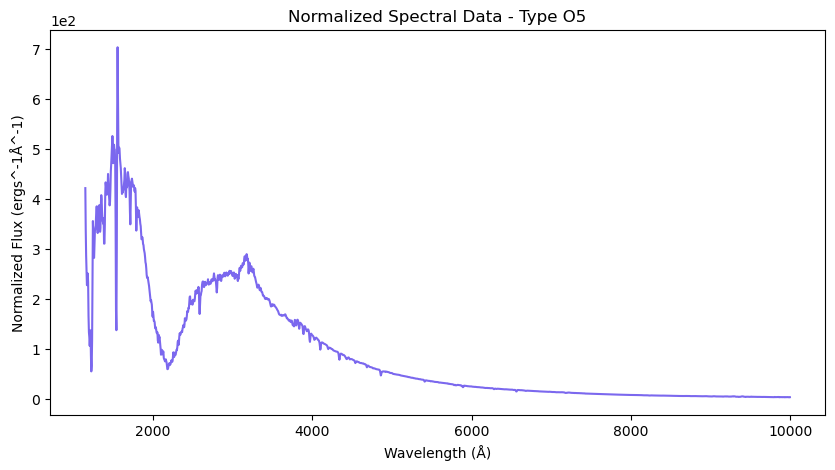

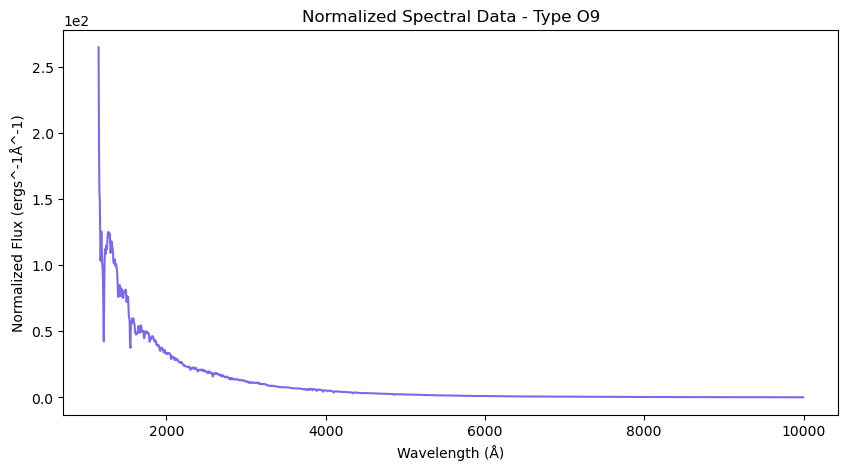

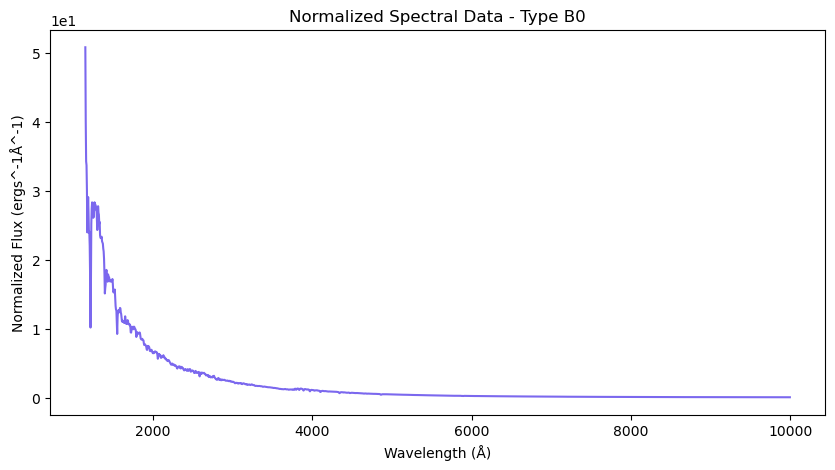

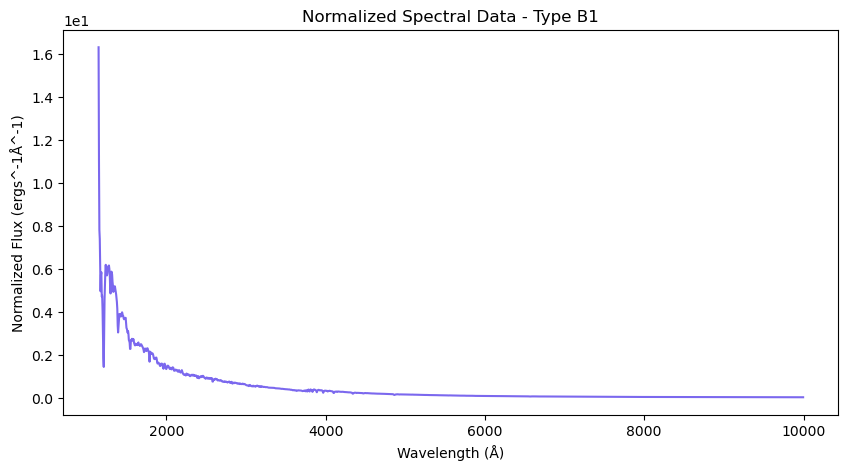

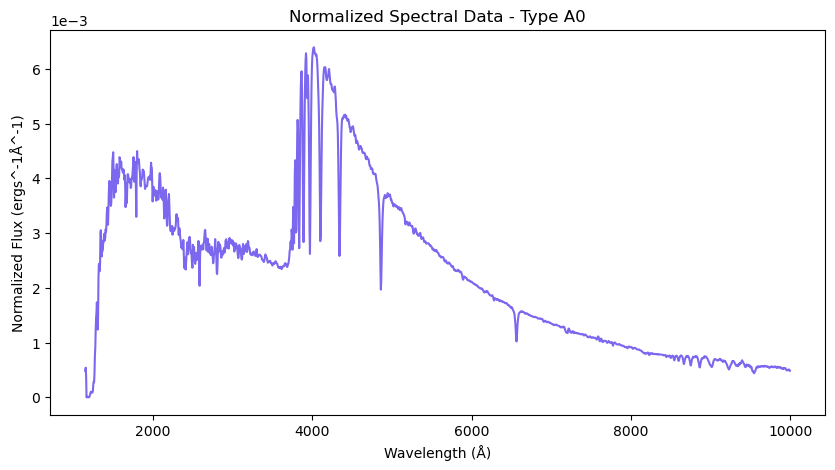

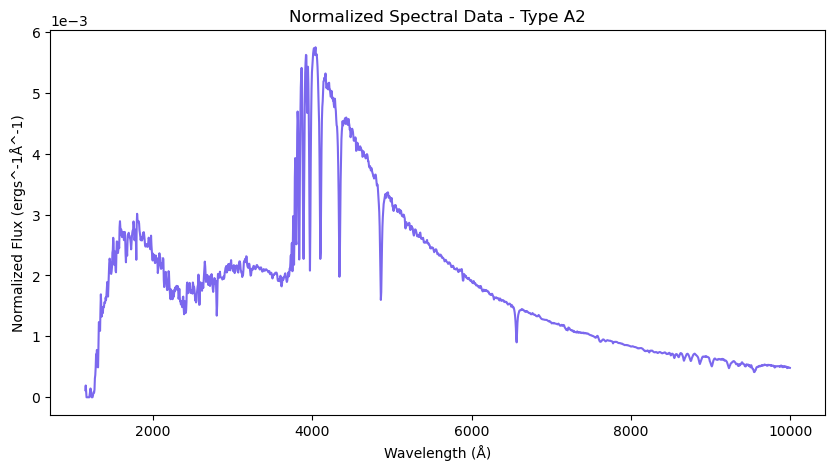

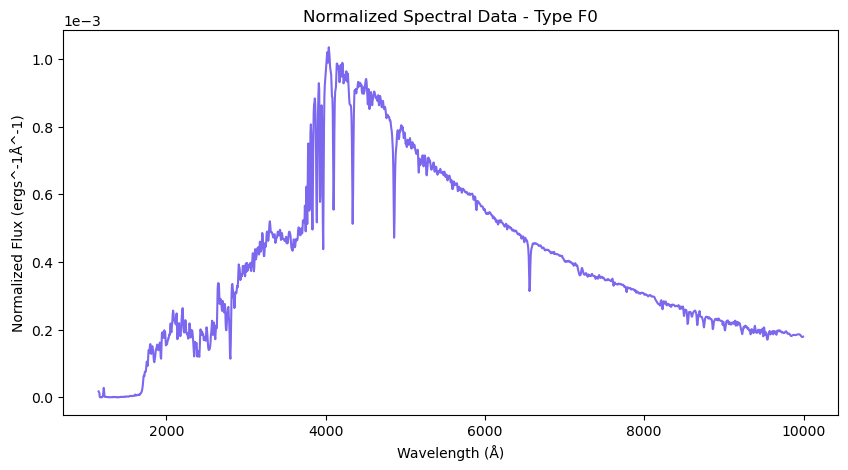

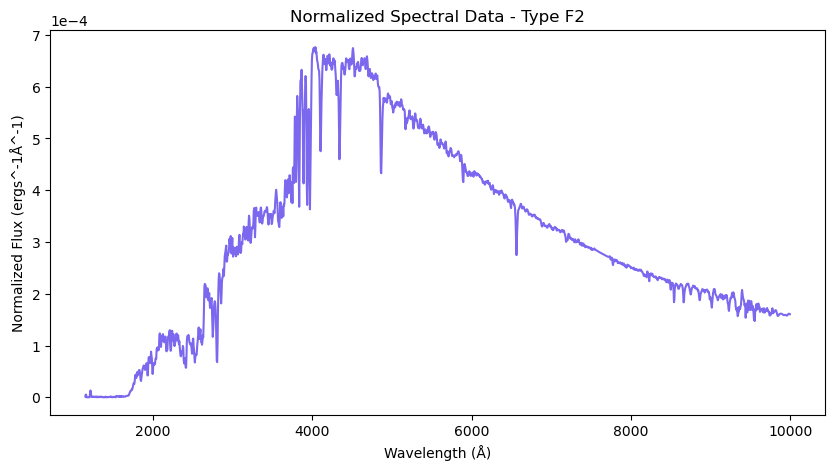

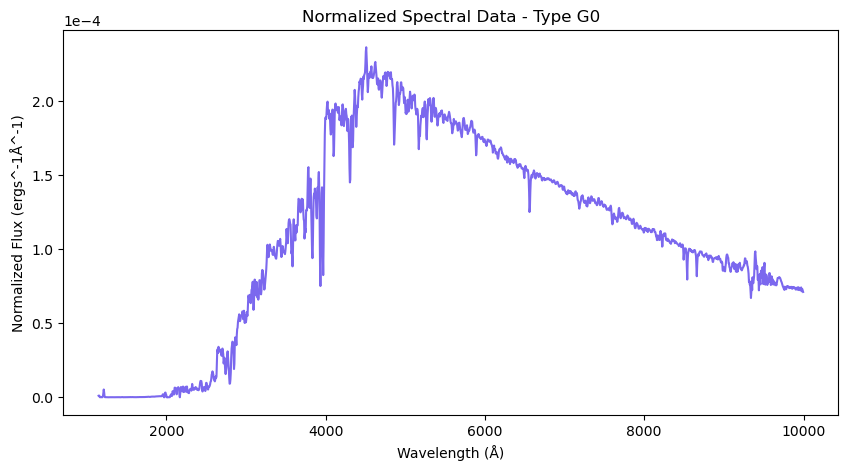

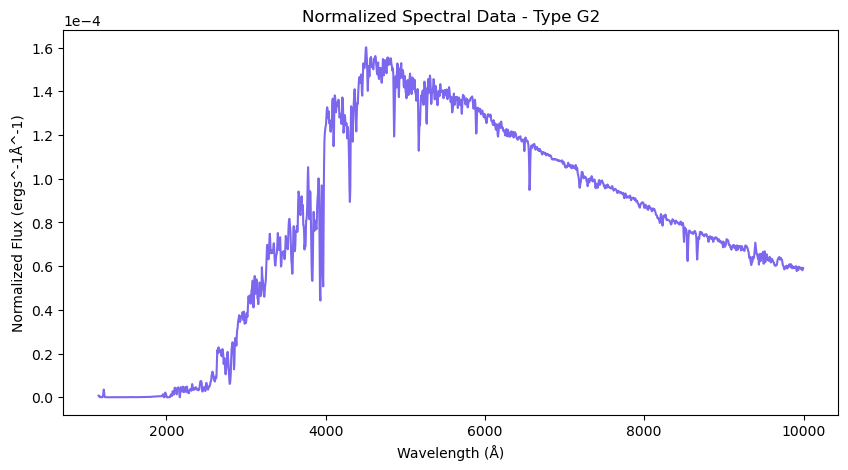

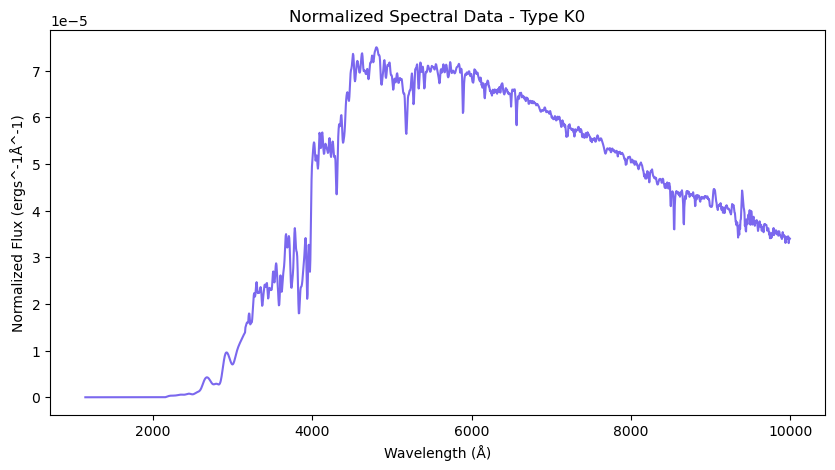

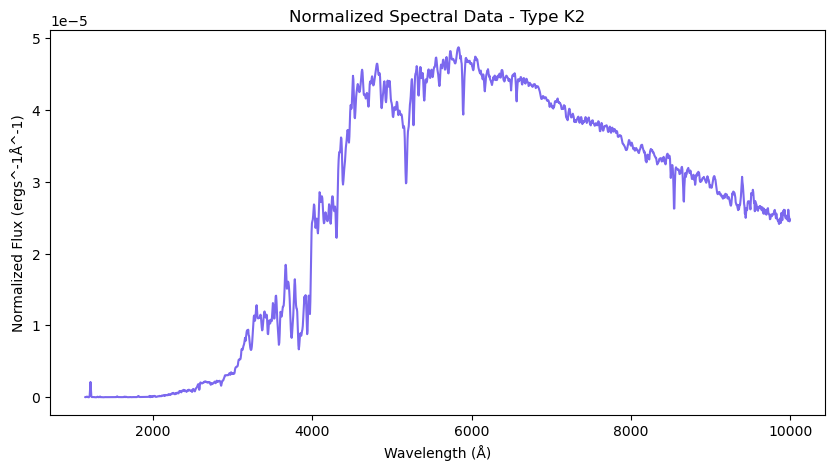

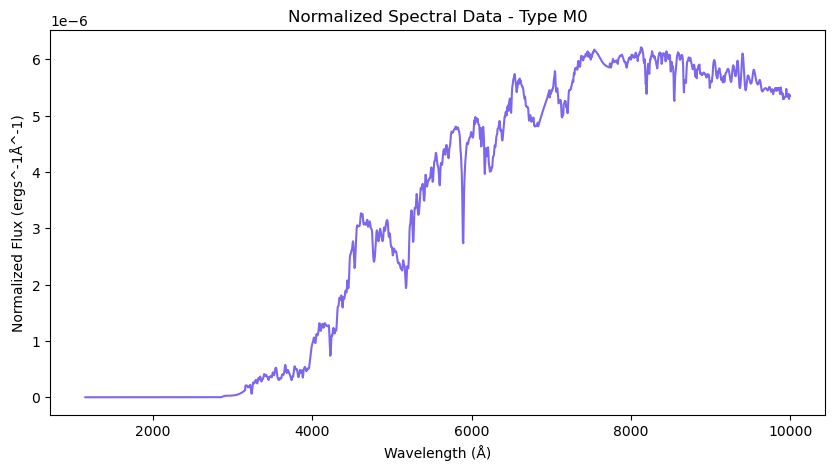

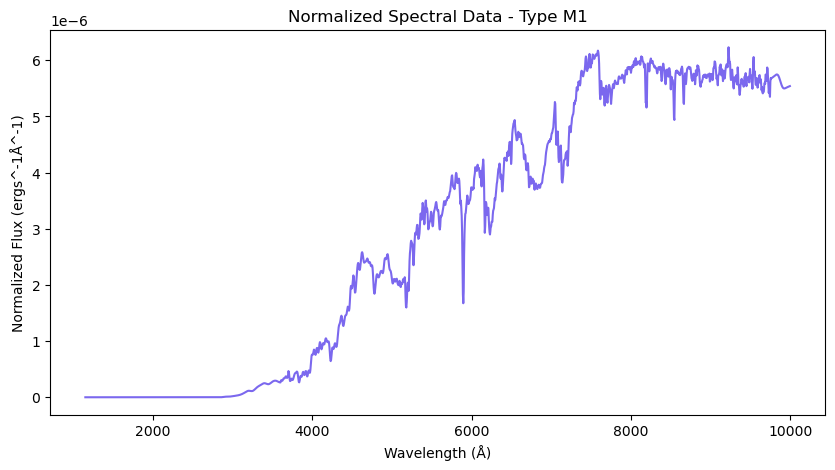

In [16]:
# Intrinsic luminosity dictionary

intrinsic_lum = {
    'O5': 846000, 'O9': 95000,
    'B0': 20000, 'B1': 4600,
    'A0': 22, 'A2': 18,
    'F0': 4.3, 'F2': 3.3,
    'G0': 1.3, 'G2': 1,
    'K0': 0.54, 'K2': 0.38,
    'M0': 0.069, 'M1': 0.064
}

# Spectra URLs dictionary with explicit spectral type mapping
spectra_urls = {
    "O5": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uko5v.fits",
    "O9": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uko9v.fits",
    "B0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukb0v.fits",
    "B1": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukb1v.fits",
    "A0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uka0v.fits",
    "A2": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uka2v.fits",
    "F0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukf0v.fits",
    "F2": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukf2v.fits",
    "G0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukg0v.fits",
    "G2": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukg2v.fits",
    "K0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukk0v.fits",
    "K2": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukk2v.fits",
    "M0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukm0v.fits",
    "M1": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukm1v.fits"
}

# Download the spectra data
spectra = {key: download_spectrum_ftp(url) for key, url in spectra_urls.items()}

for spectral_type, fits_data in spectra.items():
    # Obtain the header and data from the FITS file
    header, data = open_fits_from_data(fits_data)

    # Normalize the spectrum relative to the luminosity
    wavelength, normalized_spectrum, total_luminosity = normalize_spectrum_to_luminosity(header, data)

    # Get the intrinsic luminosity
    intrinsic_luminosity = intrinsic_lum[spectral_type]

    # Multiply the normalized spectrum by the intrinsic luminosity
    intrinsic_normalized_spectrum = normalized_spectrum * intrinsic_luminosity

    # print(f'For {spectral_type} we have intrinsic normalized luminosity : {intrinsic_normalized_spectrum}')
    # Plot the spectrum
    plt.figure(figsize=(10, 5))
    plt.plot(wavelength[wavelength<10000],
             intrinsic_normalized_spectrum[wavelength<10000],
             color='mediumslateblue')
    plt.xlabel('Wavelength (Å)')
    plt.ylabel('Normalized Flux (ergs^-1Å^-1)') # ergs−1A−1
    plt.title(f'Normalized Spectral Data - Type {spectral_type}')
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    plt.show()


In [182]:
# try to create STAR class
import numpy as np
from astropy.constants import sigma_sb, L_sun, M_sun, R_sun
import astropy.units as u


class STAR:

    def __init__(self, mass):

        self.mass = mass*M_sun
        self.born = 0 * u.Gyr
        self.stage = self.born
        self.branch = 'MS'
        self.properties()

    def properties(self):

        # Using Mass-Luminosity relation
        if self.mass/M_sun < 0.43:
            self.luminosity = 0.23 * ((self.mass/M_sun) ** 2.3)* L_sun
        elif 0.43 <= self.mass/M_sun < 2.0:
            self.luminosity = ((self.mass/M_sun) ** 4.0) * L_sun
        elif 2.0 <= self.mass/M_sun < 55:
            self.luminosity = 1.4 * L_sun * ((self.mass/M_sun) ** 3.5)
        elif 55 <= self.mass/M_sun:
            self.luminosity = 32000 * (self.mass/M_sun) * L_sun

        # Using stafan-boltzmann law
        sigma = sigma_sb.to(u.W / (u.m**2 * u.K**4))
        self.radii = R_sun * (self.mass /M_sun)**0.8
        denominator = (4 * np.pi * (self.radii**2) * sigma)
        self.temperature = ((self.luminosity / denominator) ** 0.25)
        
        if self.temperature.value >= 33000:
            self.spectral_type = 'O'
        elif self.temperature.value>= 10000:
            self.spectral_type = 'B'
        elif self.temperature.value >= 7300:
            self.spectral_type = 'A'
        elif self.temperature.value >= 6000:
            self.spectral_type = 'F'
        elif self.temperature.value >= 5300:
            self.spectral_type = 'G'
        elif self.temperature.value >= 3900:
            self.spectral_type = 'K'
        else:
            self.spectral_type = 'M'

    def update(self, t):
        cons = (10* u.Gyr)*(M_sun**3)
        self.t_ms = cons / (self.mass**3)

        life = t - self.stage

        if (self.mass/M_sun) < 5:
            if life > self.t_ms:
                if self.branch == 'MS':
        else:
            if life > self.t_ms:
                self.branch = "Dead"

In [181]:
age_uni

<Quantity 13.7976159 Gyr>

In [187]:
10* u.Gyr = 1 / STAR(1).mass**3

SyntaxError: cannot assign to expression here. Maybe you meant '==' instead of '='? (426735051.py, line 1)

In [196]:
(10* u.Gyr)*(M_sun**3)

<Quantity 7.86172288e+91 kg3 Gyr>

In [198]:
 def update_time(self, new_time):
      """
        Updates the star to the current time.
      """
      lifetime = new_time - self.start_of_stage
      if self.mass < 5:
        if lifetime > self.time_in_stage:
          if self.stage >= 3:
            return
          self.start_of_stage = self.start_of_stage + self.time_in_stage
          match self.stage:
            case 0:
              self.time_in_stage = 1
              self.update_spectrum(spectral_dict[clase_gigante(self.mass)][-1])
              self.stage = 1
              self.Class = "Red Giant"
            case 1:
              self.update_spectrum(spectral_dict[clase_horizontal(self.mass)][-1])
              self.time_in_stage = 0.1
              self.stage = 2
              self.Class = "Horizontal Branch"
            case 2:
              self.empty_spectrum() # make the spectrum into zeroes
              self.stage = 3
              self.Class = "Dead"
          self.update_time(new_time)
      else:
        if lifetime > self.time_in_stage:
          self.empty_spectrum()
          self.Class = "Dead"

<Quantity 10. Gyr>